## Notebook for segmenting bacteria using omnipose

**Questions/feedback to Marvin Albert @ IAH (marvin.albert@pasteur.fr)**

### This notebook:
- segments bacteria using omnipose
- uses a pretrained omnipose segmentation model provided in a separate file (path to model needs to be indicated!)
- uses the CPU version of omnipose to avoid installation problems
- visualizes and saves the results

### Installation instructions:
- (if not already done) download and install "anaconda" or "miniconda": https://docs.conda.io/en/latest/miniconda.html
- execute the following commands in an anaconda terminal:
    - `conda create --name omnipose python=3.9`
    - `conda activate omnipose`
    - `pip install git+https://github.com/guiwitz/cellpose.git omnipose matplotlib jupyter scikit-image scikit-learn tifffile ipympl pandas ipython ipyfilechooser ipywidgets==7.6 tqdm`
- this thread contains useful information regarding the current state of omnipose/cellpose: https://forum.image.sc/t/omnipose-over-segmenting-filamentous-bacteria/63560/2

### Usage instructions:
- open a terminal and activate the correct environment:
    - `conda activate omnipose`
- start jupyter notebook:
    - `jupyter notebook`
    - in case you have conflicting anaconda/miniconda environments, launch the notebook with an extended path, e.g.:
      `/opt/anaconda3/envs/omnipose/bin/jupyter notebook`
- open this notebook file and execute cell by cell

---
### Run the following line to make sure all necessary software is installed
This needs to be done only once and the long output of the cell can be hidden by clicking on the stripe on its left.

---

### Set input file parameters
- Indicate the input paths in the cell below OR select the paths using the file dialog shown in the second cell:
    - directory containing input images
    - omnipose model file to be used for segmentation
- Outputs will be saved under `<input-dir>/analysis_results`

In [1]:
input_dir = "../data"
model_file = "models/cellpose_residual_on_style_on_concatenation_off_omni_tds_omnipose_laura_maxime_2022_08_25_19_21_43.305437_epoch_9999"

In [2]:
# Load modules

import os, sys, copy
import skimage, tifffile
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy import ndimage
from tqdm import tqdm
from cellpose import models
from IPython.display import display
from ipyfilechooser import FileChooser

class stdout_suppressor(object):
    def __enter__(self):
        self.stdout = sys.stdout
        sys.stdout = self
    def __exit__(self, type, value, traceback):
        sys.stdout = self.stdout
    def write(self, x): pass

%matplotlib widget

input_dir_c = FileChooser(show_only_dirs=True, select_default=True, title='Choose an input file directory:')
try:
    input_dir_c.default_path = input_dir
except:
    input_dir_c.default_path = os.getcwd()
input_dir_c.reset()

model_file_c = FileChooser(show_only_dirs=False, select_default=True, title='Choose an omnipose segmentation model:')
try:
    model_file_c.default_path = os.path.dirname(model_file)
    model_file_c.default_filename = os.path.basename(model_file)
except:
    model_file_c.default_path = os.getcwd()
model_file_c.reset()

display(input_dir_c)
display(model_file_c)

FileChooser(path='/home/malbert/projects/manina/bacteria_segtrack/data/tub/mTub_ICY', filename='', title='Choo…

FileChooser(path='/home/malbert/projects/manina/bacteria_segtrack/models', filename='cellpose_residual_on_styl…

---
### Set parameters relevant to processing
- Make sure the parameters in the cell below are right.
- The second cell below finds the files in the input folders and shows the channels chosen for segmentation and analysis, using the example of the first input file.

In [2]:
# Physical distance between pixels in um
spacing_xy = 0.063

# Channels to process for
# - segmentation: index of the phase contrast channel
# - analysis: index of the fluorescence channel
ch_segmentation = 0
ch_analysis = 0

# Options for background estimation:
# 'inverted_mask': use average of image under inverted segmentation mask
# 'percentile': take fifth percentile of entire image
background_estimation_method = 'inverted_mask'

# Parameters for filtering cells in the results table
# minimum area in um
min_area_um = 0.5

Files to be processed:

GMT15_pLK300_WT_01_055_R3D-1.tif
sigB_mbtI_hupB_7H9_palmiticacid01_011_R3D-1.tif
sigB_7H9topalmiticacid02[at27]_R3D-2.tif
GMT15_pLK300_WT_01_143_R3D-127.tif
HUPB_LPT3_LPT11_LOWIRON01_002_R3D-1.tif
GMT15_pLK300_WT_01_143_R3D-1.tif
HUPB_LPT3_LPT11_LOWIRON01_015_1.tif
LKT2_CIP_FARO_01_011_R3D_FUS-26.tif
LKT2_CIP_FARO_01_108_R3D_FUS-12.tif
LKT2_CIP_FARO_01_011_R3D_FUS-68.tif
LKT2_CIP_FARO_01_196_R3D_FUS-1.tif
sigB_mbtI_hupB_7H9_palmiticacid01_05_R3D-1.tif
LKT2_CIP_FARO_01_108_R3D_FUS-1.tif

Visualization of chosen channels:



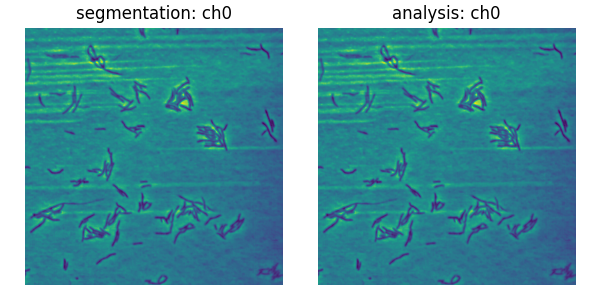

In [3]:
# find files to segment

def recursive_search(file_or_dir):
    
    fns, fns_m = [], []
    
    if os.path.isdir(file_or_dir):
        for fod in os.listdir(file_or_dir):
            if fod == 'analysis_results': continue
            # print(fod)
            fod = os.path.join(file_or_dir, fod)
            fn, fn_m = recursive_search(fod)
            fns += fn
            fns_m += fn_m
            
    else:
        if file_or_dir.endswith('.tif') and not file_or_dir.endswith('_masks.tif'):
            fns.append(file_or_dir)
                
    return fns, fns_m

input_dir = input_dir_c.selected_path
model_path = model_file_c.selected

fns, fns_m = recursive_search(input_dir)
print('Files to be processed:\n')
print('\n'.join([os.path.basename(fn) for fn in fns]))
print('\nVisualization of chosen channels:\n')

# The output of this cell lets the user verify
# that the channels have been properly selected

def read_image(fn):
    
    # load first image of the dataset
    img = tifffile.imread(os.path.join(fn))

    # load in image axes as CXY
    # add dummy dimension in case there's no channel axis specified
    if img.ndim == 2:
        img = img[None]
        
    return img

img = read_image(fns[0])

fig, axs = plt.subplots(1, 2, figsize=(3*2, 3))
for ich, ch in enumerate([ch_segmentation, ch_analysis]):
    ax = axs[ich]
    
    ax.imshow(img[ch])
    ax.axis('off')
    ax.set_title('%s' %(['segmentation: ch%s' %ch_segmentation,
                         'analysis: ch%s' %ch_analysis][ich]))

plt.tight_layout()

---
### Process images
The cell below will process all images found in the input folder and save the results to a subfolder <input-dir>/analysis_results.

In [4]:
# This cell performs the analysis and saves the results

# Update paths to file in case they changed
input_dir = input_dir_c.selected_path
model_path = model_file_c.selected

# Create output directory if it doesn't exist yet
output_dir = os.path.join(input_dir, 'analysis_results')
if not os.path.exists(output_dir): os.makedirs(output_dir)

# Load pretrained omnipose model
model = models.CellposeModel(gpu=False, pretrained_model=model_path)

# Process each input file
border_mode = 'thick'
final_df, final_df_f = [], []
for fn in tqdm(fns[:]):

    # Read image
    img = read_image(fn)

    # Segment cells
    with stdout_suppressor():
        seg = model.eval(img[ch_segmentation][None], channels=[0,0], omni=True, cluster=True)[0].astype(np.uint16)
    borders = skimage.segmentation.find_boundaries(seg, mode=border_mode)
    
    # Extract properties from cell masks
    
    if background_estimation_method == 'percentile':
        # estimate the fluorescent background
        # method 1: 5th percentile of the entire image
        b = np.percentile(img[ch_analysis], 5)
    elif background_estimation_method == 'inverted_mask':
        # use the average intensitiy of the
        # inverted segmentation mask
        # (including an area around the cells that is not considered)
        bmask = ~ndimage.binary_dilation(seg, iterations=50)
        b = np.mean(img[ch_analysis][bmask])
    else:
        raise(Exception("background_estimation_method must be either 'percentile' or 'inverted_mask'"))
    
    # Perform measurements on cells and save them into pandas table
    properties = ['area', 'eccentricity', 'perimeter', 'intensity_mean', 'label']
    props = skimage.measure.regionprops_table(seg, img[ch_analysis].astype(float)-b, properties=properties)
    props['area_um'] = props['area'] * spacing_xy**2
    df = pd.DataFrame(props)
    
    # Filter the results table
    df_f = copy.deepcopy(df)
    df_f = df_f[df_f.area_um>min_area_um]

    # Save analysis output files
    
    # Tables
    outfn = os.path.join(output_dir, os.path.basename(fn))[:-4]+'_results_table.csv'
    df.to_csv(outfn)
    outfn = os.path.join(output_dir, os.path.basename(fn))[:-4]+'_results_table_filtered.csv'
    df_f.to_csv(outfn)

    # Segmentation in different formats
    outfn = os.path.join(output_dir, os.path.basename(fn))[:-4]+'_seg.tif'
    tifffile.imwrite(outfn, seg)

    outfn = os.path.join(output_dir, os.path.basename(fn))[:-4]+'_borders.tif'
    tifffile.imwrite(outfn, skimage.segmentation.find_boundaries(seg))

    outfn = os.path.join(output_dir, os.path.basename(fn))[:-4]+'_borders_composite.tif'
    tifffile.imwrite(outfn, np.array(list(img)+ [skimage.segmentation.find_boundaries(seg), seg]),
                     imagej=True, metadata={'axes':'CYX'})


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 13/13 [00:24<00:00,  1.90s/it]


### End of processing.
The cell below shows the filtered result table.

In [67]:
# Show filtered results table

print(df_f)

area  eccentricity   perimeter  intensity_mean  label   area_um
0    256      0.982085   87.455844       38.686366      1  1.016064
1    237      0.990241   96.183766       31.190057      2  0.940653
2    159      0.978140   68.870058       30.485894      3  0.631071
3    184      0.983028   73.154329       24.496148      4  0.730296
4    499      0.995179  185.764502       33.499241      5  1.980531
5    494      0.986798  168.793939       55.381204      6  1.960686
6     59      0.910037   30.384776       58.425772      7  0.234171
7     30      0.933673   21.899495       41.561366      8  0.119070
8    295      0.987882  105.355339       58.141027      9  1.170855
9    217      0.979217   77.213203       34.063670     10  0.861273
10   302      0.983704  100.911688       31.928915     11  1.198638
11   464      0.947682  175.681241       35.701452     12  1.841616
12   249      0.965628   78.426407       34.481044     13  0.988281
13   202      0.980595   73.740115       43.402950     14  0.801738
14    79      0.969841   42.556349       -4.033571     15  0.313551
15   182      0.983287   72.142136        5.605322     16  0.722358
16   177      0.951998   58.727922        6.922947     17  0.702513